In [1]:
from tensorflow import keras 
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np


- How to differenciate 0 and o
- How to differenciate number with decimal or not
- terms of fraction?
- How do you separate each character from a connected string?

In [2]:
from skimage.filters import sobel
from sklearn.model_selection import train_test_split, learning_curve

In [3]:
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

## Import Data

- mnist: the mnist database of handwritten digits

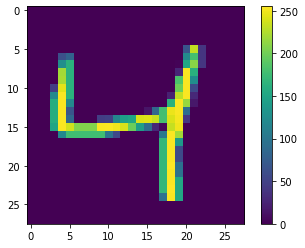

In [4]:
# impot datasets
(digits_x_train, digits_y_train), (digits_x_test, digits_y_test) = keras.datasets.mnist.load_data() #Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test)
# examine data
plt.imshow(digits_x_train[2,:,:])
plt.colorbar()
plt.show()

In [5]:
# append 2 dataset
digits_x = np.concatenate((digits_x_train, digits_x_test), axis=0)
digits_y = np.concatenate((digits_y_train, digits_y_test), axis=0)
digits_x.shape, digits_y.shape

((70000, 28, 28), (70000,))

In [6]:
# impot datasets
letters = np.loadtxt('A_Z Handwritten Data.csv', delimiter=',')

2.0


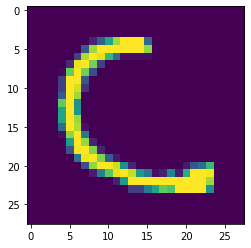

In [7]:
# examine data
n=45000
print(letters[n,0])
plt.imshow(letters[n,1:].reshape(28,28))

In [8]:
letters_x = letters[:,1:].reshape(-1,28,28)
letters_y = letters[:,0]+10

In [9]:
X = np.concatenate((digits_x,letters_x), axis=0)
y = np.concatenate((digits_y,letters_y), axis=0)
X.shape, y.shape

((442451, 28, 28), (442451,))

### Normalization, Augmentation

In [10]:
from skimage import transform

In [11]:
# rotation # width_shift # height_shift # sheer range # zoom range
def GenTrans(imgs, labels, rotation=0, width_shift=0, height_shift=0, sheer=0, zoom=0):
    # allocate y and imgs
    imgs_leng = sum((len(np.arange(-rotation, rotation+1, 5)), \
                    len(np.arange(-width_shift*28, width_shift*28,1)), \
                    len(np.arange(-height_shift*28, height_shift*28,1)), \
                    len(np.arange(-sheer, sheer, 0.05)), \
                    len(np.arange(1-zoom, 1+zoom, 0.05))))
    imgs_output = np.empty((imgs_leng*imgs.shape[0], 28,28))
    labels_output = np.empty((imgs_leng*imgs.shape[0],1))

    imgs_range = range(imgs.shape[0])
    #imgs_output = np.empty((0,28,28))
    #labels_output = np.empty((0,1))
    
    for i in imgs_range:
        #print('*',i, i*imgs_leng, (i+1)*imgs_leng)
        imgs_output[i*imgs_leng:(i+1)*imgs_leng,:,:] = GenTrans_singleImg(imgs[i,:,:], rotation, width_shift, height_shift, sheer, zoom)
        labels_output[i*imgs_leng:(i+1)*imgs_leng,:] = np.ones((imgs_leng,1))*labels[i]

        #imgs_output = np.concatenate((imgs_output, img_aug), axis=0)
        #labels_output = np.concatenate((labels_output, np.ones((img_aug.shape[0],1))*labels[i]), axis=0)
    return imgs_output, labels_output


def GenTrans_singleImg(img, rotation=0, width_shift=0, height_shift=0, sheer=0, zoom=0):
    # normalization
    img=img/255
    # rotation
    rotation_range = np.arange(-rotation, rotation+1, 5)
    rotation_img = np.zeros((len(rotation_range), img.shape[0], img.shape[1]))
    for i,angle in enumerate(rotation_range):
        rotation_img[i,:,:] = transform.rotate(img, angle=angle)
    

    # width_shift
    width_range = np.arange(-width_shift*img.shape[1], width_shift*img.shape[1],1)
    width_img = np.zeros((len(width_range), img.shape[0], img.shape[1]))
    for i,w in enumerate(width_range):
        width_img[i,:,:]=transform.warp(img, transform.AffineTransform(translation=(w,0)), mode='wrap')
    
    
    # height_shift
    height_range = np.arange(-height_shift*img.shape[1], height_shift*img.shape[1],1)
    height_img = np.zeros((len(height_range), img.shape[0], img.shape[1]))
    for i,h in enumerate(height_range):
        height_img[i,:,:]=transform.warp(img, transform.AffineTransform(translation=(0,h)), mode='wrap')
    
    # sheer
    sheer_range = np.arange(-sheer,sheer, 0.05)
    sheer_img = np.zeros((len(sheer_range), img.shape[0], img.shape[1]))
    for i,s in enumerate(sheer_range):
        sheer_img[i,:,:]=transform.warp(img, transform.AffineTransform(shear=s), order=1, preserve_range=True, mode='wrap')
    
    # zoom
    zoom_range = np.arange(1-zoom, 1+zoom, 0.05)
    zoom_img = np.zeros((len(zoom_range), img.shape[0], img.shape[1]))
    for i,z in enumerate(zoom_range):
        if z<=1:
            zoom_img[i,:,:] = transform.resize(transform.rescale(img,z), (28,28))
        else:
            img_transformed = transform.rescale(img,z)
            zoom_img[i,:,:] = img_transformed[img_transformed.shape[0]//2-14:img_transformed.shape[0]//2+14, \
                                              img_transformed.shape[1]//2-14:img_transformed.shape[1]//2+14]
    
    img_all=np.empty((0,28,28))
    for i in [rotation_img, width_img, height_img, sheer_img, zoom_img]:
        #print(img_all.shape, i.shape)
        img_all = np.concatenate((img_all,i), axis=0)
    
    return img_all




## Feature extraction


In [12]:
def Genfeature(img):
    img = img.reshape(28,28)    
    img_features = np.array([])     
    # FEATURE 1 - Pixel values
    #Add pixel values to the data frame
    pixel_values = img.reshape(-1)
    img_features = np.concatenate((img_features,pixel_values), axis=0)

    # FEATURE 2 - Bunch of Gabor filter responses
    #Generate Gabor features
    for theta in range(8):   #Define number of thetas
        theta = theta / 4. * np.pi
        for sigma in (1, 5):  #Sigma with 1 and 3
            lamda = np.pi/4
            gamma = 0.5
            ksize=9
            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
            
            #Now filter the image and add values to a new column 
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            img_features = np.concatenate((img_features,filtered_img), axis=0)
     
    # FEATURE 3 Sobel
    edge_sobel = sobel(img)
    edge_sobel = edge_sobel.reshape(-1)
    img_features = np.concatenate((img_features,edge_sobel), axis=0)

    #print('pixel_values.shape: ', filtered_img.shape)

    return img_features

## Sample and Split

In [13]:
def X_features(train_X, train_y):
    # allocate
    train_X_features = np.zeros((len(train_y), len(Genfeature(train_X[0]))))
    
    # go through each entry
    for i,k in enumerate(train_X):
        train_X_features[i,:] = Genfeature(k)
    return train_X_features

def sample_split(X, y):
    # Under sampling
    US = RandomUnderSampler(random_state=42)
    X_res, y_res = US.fit_resample(X.reshape(len(y),-1),y)

    # Augmentation
    #X_res, y_res= GenTrans(X_res.reshape(-1,28,28), y_res, width_shift=0.1, height_shift=0.1, zoom=0.1)


    # Train test split
    train_X, test_X, train_y, test_y = train_test_split(X_res.reshape(len(y_res),-1), y_res, random_state=42, train_size=0.8)

    print('-'*50)
    print('Shape of train X, test_X, train_y, test_y, Feature: \n')
    for i in [train_X, test_X, train_y, test_y]:
        print(i.shape)
    print(Genfeature(train_X[0]).shape)
    print('-'*50+'\n')

    
    # Generate features
    train_X_features = X_features(train_X, train_y)
    test_X_features = X_features(test_X, test_y)

    return train_X_features, test_X_features, train_y, test_y



## Model Building (letter and string together)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

### Balance and Split

In [15]:
train_X_features, test_X_features, train_y, test_y = sample_split(X,y)

--------------------------------------------------
Shape of train X, test_X, train_y, test_y, Feature: 

(32256, 784)
(8064, 784)
(32256,)
(8064,)
(14112,)
--------------------------------------------------



### PCA

In [16]:
pca = PCA(n_components=36)
pca_class = pca.fit_transform(train_X_features)

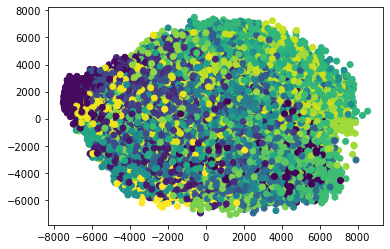

In [17]:
plt.scatter(pca_class[:,0], pca_class[:,1], c=train_y)

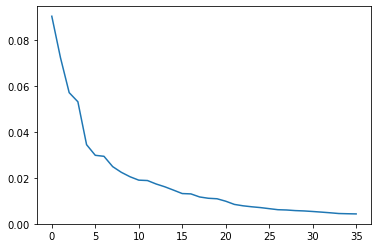

In [18]:
plt.plot(pca.explained_variance_ratio_)

### Random Forest

In [25]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(train_X_features, train_y)
pred_y = rfc.predict(test_X_features)
print(classification_report(y_pred=pred_y, y_true=test_y))

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       237
         1.0       0.95      0.98      0.97       243
         2.0       0.91      0.93      0.92       228
         3.0       0.97      0.94      0.96       228
         4.0       0.90      0.94      0.92       220
         5.0       0.94      0.89      0.92       232
         6.0       0.96      0.98      0.97       235
         7.0       0.98      0.95      0.97       233
         8.0       0.92      0.90      0.91       211
         9.0       0.92      0.88      0.90       206
        10.0       0.90      0.95      0.92       222
        11.0       0.91      0.94      0.92       225
        12.0       0.94      0.96      0.95       220
        13.0       0.92      0.92      0.92       240
        14.0       0.92      0.94      0.93       207
        15.0       0.98      1.00      0.99       199
        16.0       0.94      0.94      0.94       231
        17.0       0.92    

In [26]:
rfc_train_sizes_both, rfc_train_scores_both, rfc_test_scores_both = learning_curve(rfc, train_X_features, train_y, train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1.]))

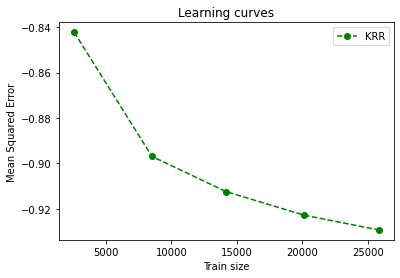

In [27]:
plt.plot(rfc_train_sizes_both, -rfc_test_scores_both.mean(1), "o--", color="g", label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

<AxesSubplot:>

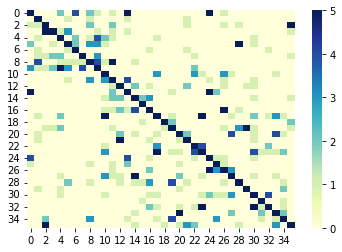

In [28]:
sns.heatmap(confusion_matrix(y_pred=pred_y, y_true=test_y), cmap="YlGnBu", vmax=5)

### SVC

In [29]:
md_svc = SVC(random_state=42)
md_svc.fit(train_X_features, train_y)

SVC(random_state=42)

In [30]:
svc_y = md_svc.predict(test_X_features)

In [31]:
print(classification_report(y_pred=svc_y, y_true=test_y))

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83       237
         1.0       0.96      0.99      0.98       243
         2.0       0.91      0.94      0.92       228
         3.0       0.97      0.92      0.94       228
         4.0       0.92      0.96      0.94       220
         5.0       0.96      0.88      0.92       232
         6.0       0.97      0.98      0.97       235
         7.0       0.97      0.94      0.96       233
         8.0       0.92      0.91      0.91       211
         9.0       0.94      0.93      0.93       206
        10.0       0.91      0.96      0.94       222
        11.0       0.91      0.96      0.93       225
        12.0       0.96      0.96      0.96       220
        13.0       0.93      0.95      0.94       240
        14.0       0.95      0.96      0.96       207
        15.0       0.99      1.00      0.99       199
        16.0       0.95      0.96      0.95       231
        17.0       0.92    

In [32]:
#svc_train_sizes_both, svc_train_scores_both, svc_test_scores_both = learning_curve(md_svc, train_X_features, train_y, train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1.]))

## Model Building (letter and string separately)

### train test split

In [16]:
digits_train_X_features, digits_test_X_features, digits_train_y, digits_test_y = sample_split(digits_x,digits_y)

--------------------------------------------------
Shape of train X, test_X, train_y, test_y, Feature: 

(50504, 784)
(12626, 784)
(50504,)
(12626,)
(14112,)
--------------------------------------------------



In [17]:
letters_train_X_features, letters_test_X_features, letters_train_y, letters_test_y = sample_split(letters_x,letters_y)

--------------------------------------------------
Shape of train X, test_X, train_y, test_y, Feature: 

(23296, 784)
(5824, 784)
(23296,)
(5824,)
(14112,)
--------------------------------------------------



In [18]:
digits_rfc = RandomForestClassifier(random_state=42)
digits_rfc.fit(digits_train_X_features, digits_train_y)
digits_pred_y = digits_rfc.predict(digits_test_X_features)
print(classification_report(y_pred=digits_pred_y, y_true=digits_test_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1217
           1       0.99      0.98      0.98      1286
           2       0.97      0.99      0.98      1257
           3       0.98      0.97      0.98      1183
           4       0.97      0.97      0.97      1304
           5       0.97      0.98      0.98      1217
           6       0.98      0.98      0.98      1309
           7       0.98      0.98      0.98      1233
           8       0.96      0.96      0.96      1308
           9       0.96      0.96      0.96      1312

    accuracy                           0.98     12626
   macro avg       0.98      0.98      0.98     12626
weighted avg       0.98      0.98      0.98     12626



In [19]:
rfc_train_sizes_digits, rfc_train_scores_digits, rfc_test_scores_digits = learning_curve(digits_rfc, digits_train_X_features, digits_train_y, train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1.]))

In [20]:
letters_rfc = RandomForestClassifier(random_state=42)
letters_rfc.fit(letters_train_X_features, letters_train_y)
letters_pred_y = letters_rfc.predict(letters_test_X_features)
print(classification_report(y_pred=letters_pred_y, y_true=letters_test_y))

              precision    recall  f1-score   support

        10.0       0.87      0.98      0.92       203
        11.0       0.96      0.94      0.95       206
        12.0       0.91      0.97      0.94       223
        13.0       0.93      0.93      0.93       231
        14.0       0.94      0.94      0.94       222
        15.0       1.00      1.00      1.00       210
        16.0       0.97      0.90      0.94       229
        17.0       0.90      0.86      0.88       209
        18.0       1.00      0.98      0.99       231
        19.0       0.93      0.92      0.93       232
        20.0       0.93      0.93      0.93       248
        21.0       0.98      0.98      0.98       238
        22.0       0.91      0.95      0.93       220
        23.0       0.90      0.90      0.90       249
        24.0       0.93      0.96      0.95       211
        25.0       0.98      0.92      0.95       213
        26.0       0.94      0.95      0.94       204
        27.0       0.93    

In [21]:
rfc_train_sizes_letters, rfc_train_scores_letters, rfc_test_scores_letters = learning_curve(letters_rfc, letters_train_X_features, letters_train_y, train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1.]))

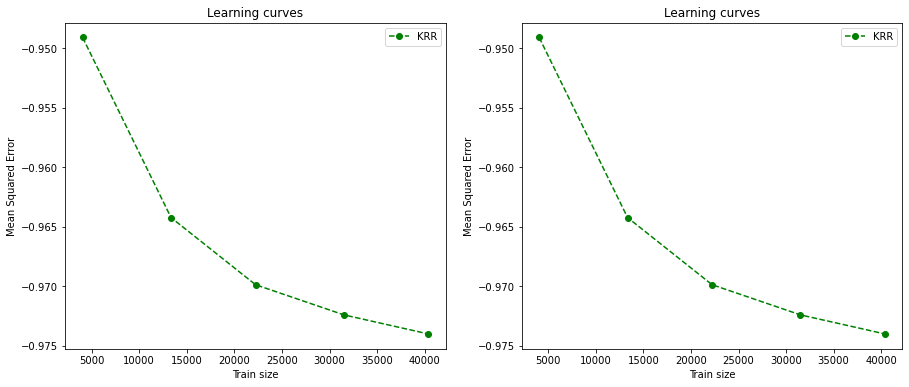

In [26]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(rfc_train_sizes_digits, -rfc_test_scores_digits.mean(1), "o--", color="g", label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(rfc_train_sizes_letters, -rfc_test_scores_letters.mean(1), "o--", color="g", label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

## Model Prediction

In [ ]:
import imutils
from imutils.contours import sort_contours

In [ ]:
image = cv2.imread('Example/images/hello_world.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)

		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

		# re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (28, 28))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")


In [ ]:
label = {i:str(i) for i in range(10)}
for i in range(10,36,1):
    label[i] = chr(i+55)

In [ ]:
plt.imshow(chars.reshape(-1,28))

In [ ]:
[label[i] for i in md_svc.predict(chars.reshape(10,-1)*255)]

In [ ]:
[label[i] for i in rfc.predict(chars.reshape(10,-1)*255)]